In [1]:
import sys
import os

from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. '/Users/darren/Documents/CSE493G1/GuitarTransformer/'
FOLDERNAME = 'drive/MyDrive/cse493g1/GuitarTransformer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

print(os.getcwd())

%cd $FOLDERNAME

Mounted at /content/drive
/content
/content/drive/MyDrive/cse493g1/GuitarTransformer


In [2]:
!pip3 install -r pip-requirement.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.2 MB/s eta 0:00:00
  Created wheel for sox: filename=sox-1.5.0-py3-none-any.whl size=40037 sha256=e4df956fa9ef71453ae566dca6964ec10460671a2b4eb1287a69e0156e70f9d7
  Stored in directory: /root/.cache/pip/wheels/74/e7/7b/8033be3ec5e4994595d01269fc9657c8fd83a0dcbf8536666a
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=e1eea56647a718a63d9827d055c3c59166087c6630c93bb84304fa2af3e07793
  Stored in directory: /root/.cache/pip/wheels/8e/

In [3]:
import torch
if not torch.cuda.is_available():
    print('cuda device not available/not selected')

else:
    print('cuda device available')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda device available


In [118]:
import math
import torch.optim as optim
import torch.nn as nn

class PositionalEncoding(nn.Module):
    # Copy from here https://h-huang.github.io/tutorials/beginner/transformer_tutorial.html

    def __init__(self, dim_model, dropout_p=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout_p)

        pe = torch.zeros(max_len, dim_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0) / dim_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)

class DecoderOnlyTransformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        dim_model,
        num_heads,
        num_decoder_layers,
        dropout_p,
        feature_dim
    ):
        super().__init__()

        # LAYERS
        self.projection = nn.Linear(feature_dim, dim_model)
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=50000
        )
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
            batch_first=True
        )
        # alternatively, fc layer from dim_model back to feature_dim to allow for any feature_dim
        self.out = nn.Linear(dim_model, feature_dim) # map back to audio features

    def forward(self, tgt):
        # project to dim_model
        tgt = self.projection(tgt)

        # Using decoder only model, so create an zero tensor for the encoder
        src = torch.zeros_like(tgt, device=tgt.device)

        # decoder layer input
        # tgt = self.positional_encoder(tgt).to(device)
        tgt = tgt.to(device)

        # mask attempt #1
        # tgt_mask = torch.triu(torch.ones(tgt.shape[1], tgt.shape[1]), diagonal=1).to(tgt.device).bool()

        # mask attempt #2
        mask = torch.triu(torch.ones(tgt.shape[1], tgt.shape[1]), diagonal=1)
        mask = mask * -1e9

        transformer_out = self.transformer(src, tgt, tgt_mask=mask, tgt_is_causal=True)
        out = self.out(transformer_out)

        return out

    def train_epoch_transformer(self, input_data, target_data, loss_fcn, optim, bs):
        """
        :param input_data: x examples with shape (num_examples, seq_length, features)
        :param target_data: y target with shape (num_examples, seq_length, features)
        :param loss_fcn: our loss function
        :param optim: our optimizer
        :param bs: batch size, number of examples per batch
        """
        self.train()
        total_loss = 0

        # shuffle the examples around
        shuffle = torch.randperm(input_data.size(0), device=input_data.device)

        for batch_i in range(math.ceil(shuffle.shape[0] / bs)):
            # Load batch of shuffled segments
            input_batch = input_data[shuffle[batch_i * bs:(batch_i + 1) * bs], :, :].to(device)
            target_batch = target_data[shuffle[batch_i * bs:(batch_i + 1) * bs],:, :].to(device)

            # Forward pass
            output = self(input_batch)

            # Calculate loss between output and target
            loss = loss_fcn(output, target_batch)

            # Backward pass and optimization
            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss += loss.item()

        return total_loss / (batch_i + 1)

    def process_data(self, input_data, target_data, loss_function, chuck_size):
        """
        :param input_data: x examples with shape (num_examples, seq_length, features)
        :param target_data: y target with shape (num_examples, seq_length, features)
        :param loss_fcn: our loss function
        :param chuck_size: the number of seq_length to process one time (avoid memory issue)
        """
        self.eval()
        with torch.no_grad():
            output = self(input_data)
            # # calculate the number of processing
            # frame_len = target_data.size()[1]
            # chuck_num = math.ceil(frame_len / chuck_size)

            # # create empty output tensor
            # output = torch.empty_like(target_data, device=target_data.device)

            # # Iterate over chucks and process the input audio
            # for l in range(chuck_num):
            #     # forward the input
            #     if l == chuck_num - 1: # the last loop
            #         output[:, l * chuck_size:, :] = self(input_data[:, l * chuck_size:, :])
            #     else: # before the last loop
            #         output[:, l * chuck_size:(l + 1) * chuck_size, :] = self(input_data[:, l * chuck_size:(l + 1) * chuck_size, :])

            # calucate the loss
            loss = loss_function(output, target_data)
        return output, loss

In [111]:
# model params
input_size = 2  # num features, 2 for stereo
output_size = 2  # num features, 2 for stereo
dim_model=128
feature_dim = 64
num_heads=2
num_decoder_layers=1
dropout_p=0.1

# train params
batch_size = 1  # num examples per batch
epochs = 30

# hyperparams
learn_rate = 1e-1

network = DecoderOnlyTransformer(dim_model=dim_model,
                                 num_heads=num_heads,
                                 num_decoder_layers=num_decoder_layers,
                                 dropout_p=dropout_p,
                                 feature_dim=feature_dim).to(device)

# Set up training optimiser + scheduler + loss fcns and training info tracker
optimiser = optim.Adam(network.parameters(), lr=learn_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.5, patience=5, verbose=True)
loss_functions = nn.SmoothL1Loss()
# loss_functions = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [62]:
import audio

# load data
def audio_preprocessing(amplifier='ht1', data_type='train', frame_len=32):

    assert amplifier in ('ht1', 'muff') , "Amplifier should be either ht1 or muff"
    assert data_type in ('train', 'val', 'test') , "data_type should be either train , val or test"

    input_loc = f'./data/{data_type}/{amplifier}-input.wav'
    target_loc = f'./data/{data_type}/{amplifier}-target.wav'

    input_waveform = audio.load_audio(input_loc)
    target_waveform = audio.load_audio(target_loc)

    # returns (frames/seq_len, features/frame_len)
    input_frames = audio.framify(input_waveform, frame_len)
    target_frames = audio.framify(target_waveform, frame_len)

    if data_type == 'train':
        seq_length = 1000
        X = audio.split_data(input_frames, seq_length).to(device)
        y = audio.split_data(target_frames, seq_length).to(device)

    else:
        seq_length = 1000  # needs to be <= max_len for positional encoding?
        X = audio.split_data(input_frames, seq_length).to(device)
        y = audio.split_data(target_frames, seq_length).to(device)

    return X, y

X_train, y_train = audio_preprocessing(amplifier='ht1', data_type='train', frame_len=feature_dim//2)
X_val, y_val = audio_preprocessing(amplifier='ht1', data_type='val', frame_len=feature_dim//2)
X_test, y_test = audio_preprocessing(amplifier='ht1', data_type='test', frame_len=feature_dim//2)

In [64]:
X_train_small = X_train[:400, :1000, :]
y_train_small = y_train[:400, :1000, :]

X_val_small = X_val[:100, :1000, :]
y_val_small = y_val[:100, :1000, :]

X_test_small = X_test[:100, :1000, :]
y_test_small = y_test[:100, :1000, :]

In [63]:
print('training:', X_train.shape, y_train.shape)
print('validation: ', X_val.shape, y_val.shape)

# print('training:', X_train_small.shape, y_train_small.shape)
# print('validation: ', X_val_small.shape, y_val_small.shape)
print('test: ', X_test.shape, y_test.shape)

training: torch.Size([468, 1000, 64]) torch.Size([468, 1000, 64])
validation:  torch.Size([70, 1000, 64]) torch.Size([70, 1000, 64])
test:  torch.Size([82, 1000, 64]) torch.Size([82, 1000, 64])


In [114]:
# TODO: train the model
import time
from collections import defaultdict
import copy

res = defaultdict(list)
best_val_loss = float('inf')
best_model = None
best_ind = -1

# Train epochs
for epoch in range(epochs):

    ep_st_time = time.time()
    # train in training
    epoch_loss = network.train_epoch_transformer(X_train_small, y_train_small, loss_functions, optimiser, batch_size)
    ep_end_time = time.time()

    val_st_time = time.time()
    # check validation result
    output, val_loss = network.process_data(X_val_small, y_val_small, loss_functions, chuck_size=1000)
    val_end_time = time.time()

    # save best model
    if val_loss < best_val_loss :
      best_model = copy.deepcopy(network)
      best_val_loss = val_loss
      best_ind = epoch

    res['epoch'].append(epoch+1)
    res['training_loss'].append(epoch_loss)
    res['training_time'].append(ep_end_time - ep_st_time)
    res['val_loss'].append(val_loss.item())
    res['val_time'].append(val_end_time - val_st_time)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss: .8f}, Val Loss: {val_loss: .8f}")

Epoch 1, Loss:  0.04519733, Val Loss:  0.03466944
Epoch 2, Loss:  0.04507763, Val Loss:  0.03479676
Epoch 3, Loss:  0.04631768, Val Loss:  0.03467889
Epoch 4, Loss:  0.04513223, Val Loss:  0.03542263
Epoch 5, Loss:  0.05083508, Val Loss:  0.03468352
Epoch 6, Loss:  0.04510426, Val Loss:  0.03465143
Epoch 7, Loss:  0.04511266, Val Loss:  0.03467235
Epoch 8, Loss:  0.04508258, Val Loss:  0.03468432
Epoch 9, Loss:  0.04509851, Val Loss:  0.03566210
Epoch 10, Loss:  0.04510253, Val Loss:  0.03468686
Epoch 11, Loss:  0.04508959, Val Loss:  0.03469483
Epoch 12, Loss:  0.13235914, Val Loss:  0.03472217
Epoch 13, Loss:  0.04553984, Val Loss:  0.03389965
Epoch 14, Loss:  0.04510727, Val Loss:  0.03467396
Epoch 15, Loss:  0.04550579, Val Loss:  0.03467144
Epoch 16, Loss:  0.04530069, Val Loss:  0.03469538
Epoch 17, Loss:  0.04869528, Val Loss:  0.03467854
Epoch 18, Loss:  0.04515571, Val Loss:  0.03468248
Epoch 19, Loss:  0.04521812, Val Loss:  0.03467135
Epoch 20, Loss:  0.04508352, Val Loss:  

In [115]:
import pandas as pd
res_table = pd.DataFrame(res)

training_time = res_table['training_time'].sum()
print(f'training_time for {epochs} epochs: {training_time} sec')
print(f'best epoch is {best_ind+1}')
res_table

training_time for 30 epochs: 276.80973076820374 sec
best epoch is 13


,epoch,training_loss,training_time,val_loss,val_time
0,1,0.045197,9.268609,0.034669,0.003805
1,2,0.045078,8.956498,0.034797,0.006694
2,3,0.046318,8.823655,0.034679,0.003878
3,4,0.045132,9.273229,0.035423,0.003932
4,5,0.050835,9.186018,0.034684,0.003979
5,6,0.045104,8.586137,0.034651,0.004231
6,7,0.045113,9.752650,0.034672,0.003944
7,8,0.045083,10.649036,0.034684,0.003829
8,9,0.045099,8.747080,0.035662,0.005778
9,10,0.045103,8.897594,0.034687,0.004001


In [116]:
test_st_time = time.time()
output, test_loss = best_model.process_data(X_test_small, y_test_small, loss_functions, chuck_size=1000)
test_end_time = time.time()
print(f'test loss: {test_loss:.6f}')
print(f'test time: {test_end_time - test_st_time} sec')

test loss: 0.048197
test time: 0.007096767425537109 sec


tensor([0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124,
        0.0124, 0.0124, 0.0124, 0.0124, 

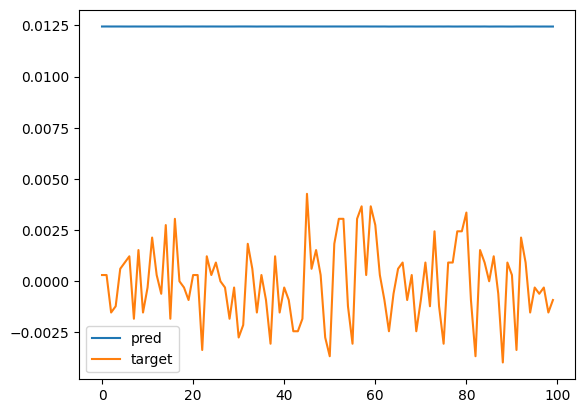

In [117]:
import numpy as np
import matplotlib.pyplot as plt

y_test_pred = output[0, :, 0][:100].to('cpu')
y_test_true = y_test[0, :, 0][:100].to('cpu')
print(output[0, :, 0])
plt.plot(range(len(y_test_pred)), y_test_pred, label='pred')
plt.plot(range(len(y_test_true)), y_test_true, label='target')
plt.legend()